# Question 1

#Packages

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd
%cd /content/drive/MyDrive/Colab\ Notebooks/Deep \Learning/Hw4/Q1

/content
/content/drive/MyDrive/Colab Notebooks/Deep Learning/Hw4/Q1


# Data Preprocess

In [ ]:
filepath = 'ferdousi.txt'
text = open(filepath, 'rb').read()
text = str(text.decode('utf-8'))

text = text.replace("\t"," \t ").replace("\n", " \n ")
corpusList = [w for w in text.split(' ')] 
corpus_words = [i for i in corpusList if i]
map(str.strip, corpus_words)
textfile = corpus_words.pop(0)
n_beyts = ' '.join([corpus_words.pop(0) for i in range(6)])
print(textfile)
print(n_beyts)

In [ ]:
vocab = sorted(set(corpus_words))
print('Corpus length (in words):', len(corpus_words))
print('Unique words in corpus: {}'.format(len(vocab)))
word2idx = {u: i for i, u in enumerate(vocab)}
idx2words = np.array(vocab)
word_as_int = np.array([word2idx[c] for c in corpus_words])

Corpus length (in words): 667783
Unique words in corpus: 18012


In [ ]:
seqLength = 20
examples_per_epoch = len(corpus_words)//(seqLength + 1)
wordDataset = tf.data.Dataset.from_tensor_slices(word_as_int)
sequencesOfWords = wordDataset.batch(seqLength + 1, drop_remainder=True)
def split_input_target(chunk):
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text, target_text

dataset = sequencesOfWords.map(split_input_target)
BATCH_SIZE = 64
BUFFER_SIZE = 100
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
def generate_text(model, start_string, temperature = 1.0):
  num_generate = 60
  start_string_list =  [w for w in start_string.split(' ')]
  input_eval = [word2idx[s] for s in start_string_list]
  input_eval = tf.expand_dims(input_eval, 0)
  text_generated = []
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      predictions = tf.squeeze(predictions, 0)
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      input_eval = tf.expand_dims([predicted_id], 0)
      text_generated.append(idx2words[predicted_id])
  return (start_string + ' '.join(text_generated))

# Model (LSTM)

In [ ]:
def create_model_lstm(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [ ]:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

lstm_model = create_model_lstm(vocab_size = len(vocab), embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=BATCH_SIZE)
lstm_model.summary()
lstm_model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (64, None, 256)           4611072   
                                                                 
 lstm_19 (LSTM)              (64, None, 1024)          5246976   
                                                                 
 dense_21 (Dense)            (64, None, 18012)         18462300  
                                                                 
Total params: 28,320,348
Trainable params: 28,320,348
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = lstm_model.fit(dataset, epochs=50)

Epoch 1/50
496/496 [==============================] - 39s 77ms/step - loss: 5.9839 - accuracy: 0.1787
Epoch 2/50
496/496 [==============================] - 38s 76ms/step - loss: 5.2989 - accuracy: 0.2170
Epoch 3/50
496/496 [==============================] - 38s 77ms/step - loss: 4.9251 - accuracy: 0.2407
Epoch 4/50
496/496 [==============================] - 38s 77ms/step - loss: 4.6400 - accuracy: 0.2571
Epoch 5/50
496/496 [==============================] - 38s 77ms/step - loss: 4.4056 - accuracy: 0.2704
Epoch 6/50
496/496 [==============================] - 38s 77ms/step - loss: 4.1959 - accuracy: 0.2823
Epoch 7/50
496/496 [==============================] - 38s 77ms/step - loss: 4.0134 - accuracy: 0.2938
Epoch 8/50
496/496 [==============================] - 38s 77ms/step - loss: 3.8532 - accuracy: 0.3069
Epoch 9/50
496/496 [==============================] - 38s 76ms/step - loss: 3.7134 - accuracy: 0.3198
Epoch 10/50
496/496 [==============================] - 38s 76ms/step - loss: 3.587

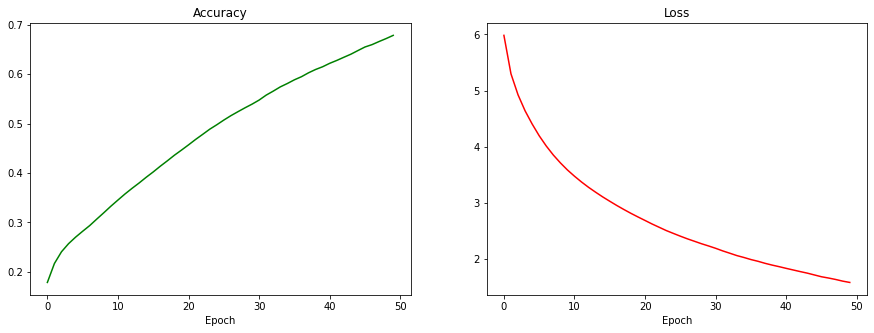

In [ ]:
# PLOT ACCURACY AND LOSS OVER EPOCHS
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(history.history['accuracy'], c='green')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.subplot(122)
plt.plot(history.history['loss'], c='red')
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
main_lstm_model = create_model_lstm(vocab_size = len(vocab), embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=1)
main_lstm_model.set_weights(lstm_model.get_weights())
main_lstm_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (1, None, 256)            4611072   
                                                                 
 lstm_20 (LSTM)              (1, None, 1024)           5246976   
                                                                 
 dense_22 (Dense)            (1, None, 18012)          18462300  
                                                                 
Total params: 28,320,348
Trainable params: 28,320,348
Non-trainable params: 0
_________________________________________________________________


In [ ]:
main_lstm_model.save("lstm_model.h5")

## Generative Function

In [ ]:
main_lstm_model = tf.keras.models.load_model('lstm_model.h5')
main_lstm_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (1, None, 256)            4611072   
                                                                 
 lstm_20 (LSTM)              (1, None, 1024)           5246976   
                                                                 
 dense_22 (Dense)            (1, None, 18012)          18462300  
                                                                 
Total params: 28,320,348
Trainable params: 28,320,348
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(generate_text(main_lstm_model, start_string=u"که ایران چوباغیست خرم بهار", temperature=0.5))

که ایران چوباغیست خرم بهار
 که هرگز مبادا بر تاجور 
 همی رفت با جامه و گوهر و سیم و بوم 
 کزان بیشتر سوی ایوان به جنگ 
 اگر خود بمانی و نه آیین بود 
 ورا پیش بیژن بگفت این سخن 
 که از رای کم بود بی نهان 
 اگر تو ندانی همی این سخن 
 که باید که با ما


# Model (GRU)

In [ ]:
def create_model_gru(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [ ]:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

gru_model = create_model_gru(vocab_size = len(vocab), embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=BATCH_SIZE)

gru_model.summary()

gru_model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (64, None, 256)           4611072   
                                                                 
 gru_4 (GRU)                 (64, None, 1024)          3938304   
                                                                 
 dense_19 (Dense)            (64, None, 18012)         18462300  
                                                                 
Total params: 27,011,676
Trainable params: 27,011,676
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = gru_model.fit(dataset, epochs=50)

Epoch 1/50
496/496 [==============================] - 38s 74ms/step - loss: 5.7901 - accuracy: 0.1948
Epoch 2/50
496/496 [==============================] - 37s 74ms/step - loss: 4.8244 - accuracy: 0.2495
Epoch 3/50
496/496 [==============================] - 37s 74ms/step - loss: 4.3271 - accuracy: 0.2770
Epoch 4/50
496/496 [==============================] - 37s 75ms/step - loss: 3.9416 - accuracy: 0.3039
Epoch 5/50
496/496 [==============================] - 37s 74ms/step - loss: 3.6076 - accuracy: 0.3356
Epoch 6/50
496/496 [==============================] - 37s 74ms/step - loss: 3.3093 - accuracy: 0.3710
Epoch 7/50
496/496 [==============================] - 37s 74ms/step - loss: 3.0579 - accuracy: 0.4060
Epoch 8/50
496/496 [==============================] - 37s 74ms/step - loss: 2.8467 - accuracy: 0.4386
Epoch 9/50
496/496 [==============================] - 37s 74ms/step - loss: 2.6675 - accuracy: 0.4679
Epoch 10/50
496/496 [==============================] - 37s 74ms/step - loss: 2.510

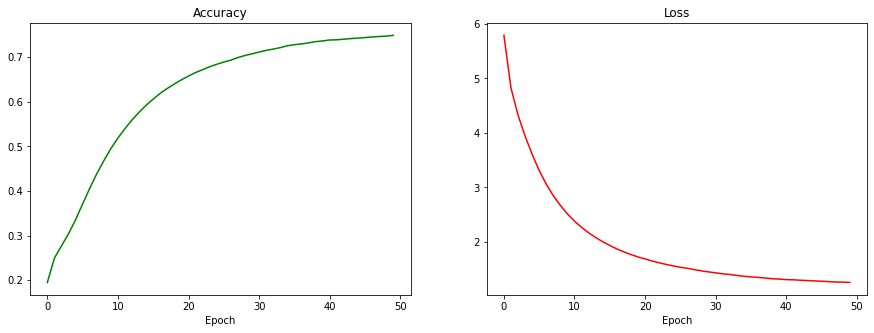

In [ ]:
# PLOT ACCURACY AND LOSS OVER EPOCHS
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(history.history['accuracy'], c='green')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.subplot(122)
plt.plot(history.history['loss'], c='red')
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
main_gru_model = create_model_gru(vocab_size = len(vocab), embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=1)
main_gru_model.set_weights(gru_model.get_weights())
main_gru_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (1, None, 256)            4611072   
                                                                 
 gru_5 (GRU)                 (1, None, 1024)           3938304   
                                                                 
 dense_20 (Dense)            (1, None, 18012)          18462300  
                                                                 
Total params: 27,011,676
Trainable params: 27,011,676
Non-trainable params: 0
_________________________________________________________________


In [ ]:
main_gru_model.save("gru_model.h5")

## Generative Function

In [ ]:
main_gru_model = tf.keras.models.load_model('gru_model.h5')
main_gru_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (1, None, 256)            4611072   
                                                                 
 gru_5 (GRU)                 (1, None, 1024)           3938304   
                                                                 
 dense_20 (Dense)            (1, None, 18012)          18462300  
                                                                 
Total params: 27,011,676
Trainable params: 27,011,676
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(generate_text(main_gru_model, start_string=u"که ایران چوباغیست خرم بهار", temperature=1))

که ایران چوباغیست خرم بهار
 فرستاد پاسخ به هر مهتری 
 که ای نامور مهتر بخردان 
 چنان بد که ضحاک بر دست رستم همی داشت آموختن 
 زهر گونه ای روزگاری جوان 
 که با ما ز بهر چنین روزگار 
 به دیگر عقیق و مهان دارد و هم کمر 
 دگر نان خویش بنشاندم 
 چنان بد که بر ما ز پس
